In [1]:
from __future__ import division

In [2]:
from aqchem.chemistry import Solute
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance
import periodictable
import numpy as np

In [3]:
substances = Hp, OHm, NH4p, NH3, H2O = [
    Solute(n, formula=periodictable.formula(n)) for n in [
        'H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']]
assert (Hp.charge, OHm.charge, NH4p.charge, NH3.charge, H2O.charge) == (1, -1, 1, 0, 0)

In [4]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 1e-7, NH3: 1.0, H2O: 55.5}
x0 = [init_conc[k] for k in substances]
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr

In [5]:
reaction_system = EqSystem(equilibria, substances)

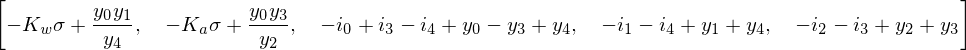

In [6]:
import sympy as sp
sp.init_printing()
ny = len(substances)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
Kw, Ka, sigma = sp.symbols('K_w K_a sigma')
w_autop.params = Kw
NH4p_pr.params = Ka
rs = EqSystem(equilibria, substances)
f = rs.f(y, i, scaling=sigma)
f

In [7]:
j = sp.Matrix(1, len(y), lambda _, q: f[q]).jacobian(y)
jarr = np.array(j.subs(zip(y,x0)))
jarr = np.asarray(jarr, dtype=np.float64)
np.linalg.inv(jarr)

array([[  1.85000006e+08,   3.33333311e-08,   3.33333345e-01,
         -3.33333344e-01,   3.33333311e-01],
       [  3.69999993e+08,  -3.33333311e-08,  -3.33333344e-01,
          3.33333345e-01,  -3.33333311e-01],
       [  1.84999987e+08,  -6.66666622e-08,   3.33333311e-01,
         -3.33333311e-01,   3.33333378e-01],
       [ -1.84999987e+08,   6.66666622e-08,  -3.33333311e-01,
          3.33333311e-01,   6.66666622e-01],
       [ -3.69999993e+08,   3.33333311e-08,   3.33333344e-01,
          6.66666655e-01,   3.33333311e-01]])

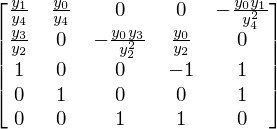

In [8]:
j

In [9]:
[s.name for s in rs.substances]

['H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']

In [10]:
rs.charge_balance_vector(), rs.atom_balance_vectors()

In [11]:
rs.rref()

In [12]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
for rxn in rs.rxns:
    rxn.params = rxn.params.subs({Kw: 1e-14, Ka: 10**-9.26})

In [13]:
res = rs.root(x0, scaling=1, logC=False, square=False)
res.success

(5, 5)
Matrix([[y_1/y_4, y_0/y_4, 0, 0, -y_0*y_1/y_4**2], [y_3/y_2, 0, -y_0*y_3/y_2**2, y_0/y_2, 0], [1, 0, 0, -1, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 0]])
[  2.4802e-07   7.2201e-07   5.7399e-07   1.0000e+00   5.5500e+01]
[  2.4802e-07   7.2201e-07   5.7399e-07   1.0000e+00   5.5500e+01]
[  2.4802e-07   7.2201e-07   5.7399e-07   1.0000e+00   5.5500e+01]
[  3.9894e-07   1.7962e-06   1.4973e-06   1.0000e+00   5.5500e+01]
[  2.5840e-07   1.6367e-06   1.4783e-06   1.0000e+00   5.5500e+01]
[  2.5479e-07   1.9571e-06   1.8023e-06   1.0000e+00   5.5500e+01]
[  1.7216e-07   2.7521e-06   2.6799e-06   1.0000e+00   5.5500e+01]
[  1.1913e-07   3.8401e-06   3.8210e-06   1.0000e+00   5.5500e+01]
[  6.9423e-08   6.0794e-06   6.1135e-06   9.9906e-01   5.5500e+01]
[  1.8582e-08   1.0602e-05   1.0703e-05   9.9667e-01   5.5499e+01]
[  8.4665e-08   2.0657e-06   2.0810e-06   1.0000e+00   5.5500e+01]
[  1.2557e-08   6.6364e-04   1.5293e-05   9.9902e-01   5.5499e+01]
[  1.3758e-08   1.0605e-05   1.0692e-05   

aqchem/equilibria.py:40: RuntimeWarning: divide by zero encountered in true_divide
  limits = c0/stoich


True

In [14]:
res = rs.root({Hp: 1e-11, OHm: 1e-3, NH4p: 1e-3, NH3: 1.0, H2O: 55.5}, scaling=1, logC=False, square=False)
res.success

(5, 5)
Matrix([[y_1/y_4, y_0/y_4, 0, 0, -y_0*y_1/y_4**2], [y_3/y_2, 0, -y_0*y_3/y_2**2, y_0/y_2, 0], [1, 0, 0, -1, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 0]])
[  2.2300e-10   1.0000e-03   1.0000e-03   1.0000e+00   5.5500e+01]
[  2.2300e-10   1.0000e-03   1.0000e-03   1.0000e+00   5.5500e+01]
[  2.2300e-10   1.0000e-03   1.0000e-03   1.0000e+00   5.5500e+01]
[  2.7791e-10   2.2425e-03   2.2425e-03   9.9876e-01   5.5499e+01]
[  1.7166e-10   2.3793e-03   2.3793e-03   9.9862e-01   5.5499e+01]
[  1.7307e-10   2.1965e-03   2.1964e-03   9.9880e-01   5.5499e+01]
[  1.3287e-10   3.5207e-03   3.5207e-03   9.9748e-01   5.5497e+01]
[  8.9958e-11   5.0335e-03   5.0335e-03   9.9597e-01   5.5496e+01]
[  2.6578e-11   8.0592e-03   8.0592e-03   9.9294e-01   5.5493e+01]
[  9.8742e-11   3.4211e-03   3.4211e-03   9.9758e-01   5.5498e+01]
[  5.4283e-11   5.0335e-03   5.0335e-03   9.9597e-01   5.5496e+01]
[  1.3898e-11   9.5721e-03   9.5721e-03   9.9143e-01   5.5491e+01]
[  1.7110e-11   1.2598e-02   1.2598e-02   

aqchem/equilibria.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= c[idx]**nr


True

In [15]:
res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e8, logC=False, square=False)

(5, 5)
Matrix([[y_1/y_4, y_0/y_4, 0, 0, -y_0*y_1/y_4**2], [y_3/y_2, 0, -y_0*y_3/y_2**2, y_0/y_2, 0], [1, 0, 0, -1, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 0]])


ValueError: f(a) and f(b) must have different signs

In [ ]:
%debug

> /usr/local/lib/python2.7/dist-packages/scipy/optimize/zeros.py(415)brentq()
    414         raise ValueError("rtol too small (%g < %g)" % (rtol, _rtol))
--> 415     r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
    416     return results_c(full_output, r)

ipdb> print(a, b)
(-0.0016994450009999997, 5549999999.999999)
ipdb> f(a)
*** TypeError: equilibrium_residual() takes at least 4 arguments (1 given)


In [ ]:
res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e16, logC=True, square=False)

In [ ]:
y_0, y_1, y_2, y_3, y_4 = y
sp.Matrix([[2*y_0*y_1**2/y_4**2, 2*y_0**2*y_1/y_4**2, 0, 0, -2*y_0**2*y_1**2/y_4**3], [2*y_0*y_3**2/y_2**2, 0, -2*y_0**2*y_3**2/y_2**3, 2*y_0**2*y_3/y_2**2, 0], [2*y_0, 0, 0, -2*y_3, 2*y_4], [0, 2*y_1, 0, 0, 2*y_4], [0, 0, 2*y_2, 2*y_3, 0]])

In [ ]:
x0

In [ ]:
from aqchem.equilibria import solve_equilibrium
print(x0)
for w in range(1,5):
    for eq in rs.rxns:
        new_x0 = solve_equilibrium(x0, eq.net_stoich(rs.substances), eq.params)
        x0 = (w*x0 + new_x0)/(w+1)
        print(x0)

In [ ]:
rs.root(x0, scaling=1e8, logC=False, square=False)